### Phase 4: Build XGboost machine learning model for traffic flow forecast

In [1]:
# measure execution time
%load_ext autotime

time: 0 ns (started: 2023-06-30 02:39:54 +03:00)


In [2]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

time: 0 ns (started: 2023-06-30 02:39:55 +03:00)


In [3]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

time: 2.56 s (started: 2023-06-30 02:39:55 +03:00)


### Load the dataset
Measure the traffic flow every 15 minutes for each path.

In [4]:
# read dataset
time_series = pd.read_csv('C:/Users/SK/Desktop/Diploma_Thesis/Datasets/San-Francisco-Yellow-Cabs/Files/time_series.txt')

# drop unecessary columns
time_series.drop(["Traj ID","Taxi ID"],axis=1,inplace=True)

# print first two rows
time_series.shape

(1000, 338)

time: 93 ms (started: 2023-06-30 02:39:58 +03:00)


In [5]:
time_series.head(3)

,Path,Length,"(Timestamp('2008-05-18 00:00:00'), Timestamp('2008-05-18 00:30:00'))","(Timestamp('2008-05-18 00:30:00'), Timestamp('2008-05-18 01:00:00'))","(Timestamp('2008-05-18 01:00:00'), Timestamp('2008-05-18 01:30:00'))","(Timestamp('2008-05-18 01:30:00'), Timestamp('2008-05-18 02:00:00'))","(Timestamp('2008-05-18 02:00:00'), Timestamp('2008-05-18 02:30:00'))","(Timestamp('2008-05-18 02:30:00'), Timestamp('2008-05-18 03:00:00'))","(Timestamp('2008-05-18 03:00:00'), Timestamp('2008-05-18 03:30:00'))","(Timestamp('2008-05-18 03:30:00'), Timestamp('2008-05-18 04:00:00'))",...,"(Timestamp('2008-05-24 19:00:00'), Timestamp('2008-05-24 19:30:00'))","(Timestamp('2008-05-24 19:30:00'), Timestamp('2008-05-24 20:00:00'))","(Timestamp('2008-05-24 20:00:00'), Timestamp('2008-05-24 20:30:00'))","(Timestamp('2008-05-24 20:30:00'), Timestamp('2008-05-24 21:00:00'))","(Timestamp('2008-05-24 21:00:00'), Timestamp('2008-05-24 21:30:00'))","(Timestamp('2008-05-24 21:30:00'), Timestamp('2008-05-24 22:00:00'))","(Timestamp('2008-05-24 22:00:00'), Timestamp('2008-05-24 22:30:00'))","(Timestamp('2008-05-24 22:30:00'), Timestamp('2008-05-24 23:00:00'))","(Timestamp('2008-05-24 23:00:00'), Timestamp('2008-05-24 23:30:00'))","(Timestamp('2008-05-24 23:30:00'), Timestamp('2008-05-25 00:00:00'))"
0,"[60678630, 60678630]",2,0,3,1,0,1,0,0,0,...,1,0,2,0,0,1,1,0,2,1
1,"[776651709, 776651709]",2,4,9,7,7,5,16,6,13,...,3,12,1,4,5,6,0,4,4,4
2,"[680243315, 680243315, 397146706, 397146706, 3...",5,2,3,3,4,3,2,2,7,...,1,4,4,2,4,2,3,1,1,0


time: 16 ms (started: 2023-06-30 02:39:58 +03:00)


In [6]:
# this list contains the column names
columns = ["Path","Length"]

# generate the columns of the dataset
i =2
while(True):
    if i == 2:
        columns.append(pd.to_datetime('2008-05-18 00:00:00'))
    else:
        columns.append(columns[i-1] + timedelta(seconds=1800))
    
    if (columns[i]>=pd.to_datetime('2008-05-24 23:59:59.000130')):
        break
    
    i+=1

# delete the last timestamp
columns.pop()

# assign new column names to our dataframe
time_series.columns = columns

# print first two rows
time_series.head(2)

,Path,Length,2008-05-18 00:00:00,2008-05-18 00:30:00,2008-05-18 01:00:00,2008-05-18 01:30:00,2008-05-18 02:00:00,2008-05-18 02:30:00,2008-05-18 03:00:00,2008-05-18 03:30:00,...,2008-05-24 19:00:00,2008-05-24 19:30:00,2008-05-24 20:00:00,2008-05-24 20:30:00,2008-05-24 21:00:00,2008-05-24 21:30:00,2008-05-24 22:00:00,2008-05-24 22:30:00,2008-05-24 23:00:00,2008-05-24 23:30:00
0,"[60678630, 60678630]",2,0,3,1,0,1,0,0,0,...,1,0,2,0,0,1,1,0,2,1
1,"[776651709, 776651709]",2,4,9,7,7,5,16,6,13,...,3,12,1,4,5,6,0,4,4,4


time: 110 ms (started: 2023-06-30 02:39:58 +03:00)


### Transform the dataset
Use melt function to convert time columns as rows and the rest of them as columns.

In [7]:
# reshape the data from column format to row format
id_cols = ['Path', 'Length']
time_cols = time_series.iloc[:,2:].columns
time_series = time_series.melt(id_vars=id_cols, value_vars=time_cols, var_name='Time Column', value_name='Traffic Flow')
time_series['Time Column'] = pd.to_datetime(time_series['Time Column'])

# sort rows by Path and Time
time_series.sort_values(by=['Path','Time Column'],inplace=True)

# print first rows of the dataset
time_series.shape

(336000, 4)

time: 453 ms (started: 2023-06-30 02:39:58 +03:00)


In [8]:
time_series.head(5)

,Path,Length,Time Column,Traffic Flow
593,"[100400941, 100400941, 100400941, 100400941, 1...",8,2008-05-18 00:00:00,4
1593,"[100400941, 100400941, 100400941, 100400941, 1...",8,2008-05-18 00:30:00,4
2593,"[100400941, 100400941, 100400941, 100400941, 1...",8,2008-05-18 01:00:00,4
3593,"[100400941, 100400941, 100400941, 100400941, 1...",8,2008-05-18 01:30:00,2
4593,"[100400941, 100400941, 100400941, 100400941, 1...",8,2008-05-18 02:00:00,9


time: 16 ms (started: 2023-06-30 02:39:58 +03:00)


Encode the path names to numerical ones for forecast

In [9]:
# convert path column from categorical to numerical
from sklearn.preprocessing import LabelEncoder

# create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder on the 'Path' column
time_series['Path'] = label_encoder.fit_transform(time_series['Path'])

# sort the data based in Path column
time_series = time_series.sort_values(by=['Path','Time Column'])

time: 625 ms (started: 2023-06-30 02:39:59 +03:00)


In [10]:
time_series.head()

,Path,Length,Time Column,Traffic Flow
593,0,8,2008-05-18 00:00:00,4
1593,0,8,2008-05-18 00:30:00,4
2593,0,8,2008-05-18 01:00:00,4
3593,0,8,2008-05-18 01:30:00,2
4593,0,8,2008-05-18 02:00:00,9


time: 15 ms (started: 2023-06-30 02:40:00 +03:00)


### Convert the time series dataset to a supervised problem
Use for each path n_in timesteps of traffic flow in the past, in order to predict the n_out traffic flow timesteps in the future.

In [11]:
from pandas import DataFrame
from pandas import concat

# create functio for generating (X, y) pairs
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('Traffic Flow %d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('Traffic Flow %d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('Traffic Flow %d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

data = pd.DataFrame()

# do the following for each path in the dataset
for item in time_series['Path'].unique():
    # call function only for traffic flow columns
    x = series_to_supervised(time_series[time_series['Path'] == item].drop(['Length','Time Column','Path'],axis=1), 5,1)
    
    # the rest of the columns are concatenated as they were
    x['Path'] = item
    x['Length'] = time_series[time_series['Path'] == item]['Length']
    data = pd.concat([data,x])

data['Time Column'] = time_series['Time Column']
time_series = data

time: 13.2 s (started: 2023-06-30 02:40:04 +03:00)


In [12]:
time_series.head()

,Traffic Flow 1(t-5),Traffic Flow 1(t-4),Traffic Flow 1(t-3),Traffic Flow 1(t-2),Traffic Flow 1(t-1),Traffic Flow 1(t),Path,Length,Time Column
5593,4.0,4.0,4.0,2.0,9.0,10,0,8,2008-05-18 02:30:00
6593,4.0,4.0,2.0,9.0,10.0,14,0,8,2008-05-18 03:00:00
7593,4.0,2.0,9.0,10.0,14.0,3,0,8,2008-05-18 03:30:00
8593,2.0,9.0,10.0,14.0,3.0,10,0,8,2008-05-18 04:00:00
9593,9.0,10.0,14.0,3.0,10.0,7,0,8,2008-05-18 04:30:00


time: 31 ms (started: 2023-06-30 02:40:17 +03:00)


### Feature Creation From Time Information
We define some features based on time series timestamps.
- Day, dayfweek, hour and minute features derive directly from the timestamp column of the dataset.
- Hour_sin and Hour_cos columns transform the hour values into a cyclic representation, where the values range from -1 to 1. This transformation is used in time series analysis to capture the periodic patterns or cyclical nature of time-related data.

In [13]:
# extract timestamp information to different columns
time_series['hour'] = time_series['Time Column'].dt.hour
time_series['dayofweek'] = time_series['Time Column'].dt.dayofweek
time_series['day'] = time_series['Time Column'].dt.day
time_series['minute'] = time_series['Time Column'].dt.minute

time: 219 ms (started: 2023-06-30 02:40:17 +03:00)


In [14]:
# circular Encoding for cyclic time features
time_series['hour_sin'] = np.sin(2 * np.pi * time_series['hour'] / 24)
time_series['hour_cos'] = np.cos(2 * np.pi * time_series['hour'] / 24)

time: 31 ms (started: 2023-06-30 02:40:17 +03:00)


### Extract features about trend of time series
- Rolling mean and rolling standard deviation are statistical measures that are commonly used in time series analysis and data smoothing. They are calculated over a sliding window or a rolling window, where the window size determines the number of consecutive data points included in the calculation.

</br>

- Rolling Mean: The rolling mean (or moving average) calculates the average value of a time series within a specific window. It smooths out short-term fluctuations and provides a smoothed representation of the data. The rolling mean at each time point is the average of the values within the window centered around that time point.

</br>

- Rolling Standard Deviation: The rolling standard deviation calculates the standard deviation of a time series within a specific window. It measures the dispersion or variability of the data points within the window. The rolling standard deviation at each time point is the standard deviation of the values within the window centered around that time point.

In [29]:
time_series['rolling_mean'] = 0
time_series['rolling_std'] = 0

time_series['rolling_mean'] = time_series.iloc[:,0:5].mean(axis=1)
time_series['rolling_std'] = time_series.iloc[:,0:5].mean(axis=1)

time: 78 ms (started: 2023-06-30 02:51:44 +03:00)


### Define Features and Labels
- Features will help the XGboost algorithm to predict the putput value, the label. We will use all the traffic flow information at previous timesteps (t-n,t-n+1...,t-2,t-1), as well as the rest of the features (time and trend information) as features.
- Label will be out target value, the Traffic Flow at timestep t.

In [30]:
# define features
features = time_series.drop(['Time Column','Traffic Flow 1(t)'],axis=1).columns

# define labels
labels = ['Traffic Flow 1(t)']

# create X_train and y_train data sets
X  = time_series[features]
y = time_series[labels]

# create X_test and y_test data sets
#X_test = test[features]
#y_test = test[labels]

time: 78 ms (started: 2023-06-30 02:51:45 +03:00)


In [31]:
print("Shape of X is: ",X.shape)
print("Shape of y is: ",y.shape)

Shape of X is:  (331000, 15)
Shape of y is:  (331000, 1)
time: 0 ns (started: 2023-06-30 02:51:46 +03:00)


### Train an XGboost model
We will fit all the data in this model!

In [32]:
import xgboost as xgb

time: 0 ns (started: 2023-06-30 02:51:47 +03:00)


In [ ]:
# define XGBoost regressor
reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    early_stopping_rounds=3,
    learning_rate=1,
    gamma=3,
    alpha=0.1
)

# train the XGBoost model with feature weights, use validation set on test data)
reg.fit(X,y, 
        eval_set=[(X,y)], 
        verbose=True)

[0]	validation_0-rmse:3.04305
[1]	validation_0-rmse:2.96481
[2]	validation_0-rmse:2.92676
[3]	validation_0-rmse:2.90050
[4]	validation_0-rmse:2.88539
[5]	validation_0-rmse:2.86208
[6]	validation_0-rmse:2.82162
[7]	validation_0-rmse:2.80631
[8]	validation_0-rmse:2.79404
[9]	validation_0-rmse:2.78515
[10]	validation_0-rmse:2.77208
[11]	validation_0-rmse:2.76634
[12]	validation_0-rmse:2.75764
[13]	validation_0-rmse:2.75028
[14]	validation_0-rmse:2.73984
[15]	validation_0-rmse:2.72827
[16]	validation_0-rmse:2.71972
[17]	validation_0-rmse:2.71311
[18]	validation_0-rmse:2.70921
[19]	validation_0-rmse:2.70253
[20]	validation_0-rmse:2.69401
[21]	validation_0-rmse:2.68574
[22]	validation_0-rmse:2.67843
[23]	validation_0-rmse:2.67144
[24]	validation_0-rmse:2.66422
[25]	validation_0-rmse:2.65845
[26]	validation_0-rmse:2.65443
[27]	validation_0-rmse:2.65067
[28]	validation_0-rmse:2.64557
[29]	validation_0-rmse:2.64048
[30]	validation_0-rmse:2.63253
[31]	validation_0-rmse:2.62430
[32]	validation_0-

[260]	validation_0-rmse:2.05544
[261]	validation_0-rmse:2.05381
[262]	validation_0-rmse:2.05218
[263]	validation_0-rmse:2.05097
[264]	validation_0-rmse:2.04953
[265]	validation_0-rmse:2.04845
[266]	validation_0-rmse:2.04719
[267]	validation_0-rmse:2.04576
[268]	validation_0-rmse:2.04471
[269]	validation_0-rmse:2.04373
[270]	validation_0-rmse:2.04281
[271]	validation_0-rmse:2.04115
[272]	validation_0-rmse:2.03916
[273]	validation_0-rmse:2.03771
[274]	validation_0-rmse:2.03642
[275]	validation_0-rmse:2.03568
[276]	validation_0-rmse:2.03402
[277]	validation_0-rmse:2.03220
[278]	validation_0-rmse:2.03072
[279]	validation_0-rmse:2.02949
[280]	validation_0-rmse:2.02788
[281]	validation_0-rmse:2.02631
[282]	validation_0-rmse:2.02544
[283]	validation_0-rmse:2.02383
[284]	validation_0-rmse:2.02216
[285]	validation_0-rmse:2.02062
[286]	validation_0-rmse:2.01945
[287]	validation_0-rmse:2.01843
[288]	validation_0-rmse:2.01719
[289]	validation_0-rmse:2.01577
[290]	validation_0-rmse:2.01396
[291]	va

[517]	validation_0-rmse:1.76825
[518]	validation_0-rmse:1.76760
[519]	validation_0-rmse:1.76724
[520]	validation_0-rmse:1.76630
[521]	validation_0-rmse:1.76530
[522]	validation_0-rmse:1.76465
[523]	validation_0-rmse:1.76410
[524]	validation_0-rmse:1.76373
[525]	validation_0-rmse:1.76340
[526]	validation_0-rmse:1.76212
[527]	validation_0-rmse:1.76106
[528]	validation_0-rmse:1.76045
[529]	validation_0-rmse:1.75952
[530]	validation_0-rmse:1.75865
[531]	validation_0-rmse:1.75808
[532]	validation_0-rmse:1.75781
[533]	validation_0-rmse:1.75774
[534]	validation_0-rmse:1.75673
[535]	validation_0-rmse:1.75539
[536]	validation_0-rmse:1.75432
[537]	validation_0-rmse:1.75399
[538]	validation_0-rmse:1.75292
[539]	validation_0-rmse:1.75212
[540]	validation_0-rmse:1.75105
[541]	validation_0-rmse:1.74988
[542]	validation_0-rmse:1.74878
[543]	validation_0-rmse:1.74766
[544]	validation_0-rmse:1.74670
[545]	validation_0-rmse:1.74599
[546]	validation_0-rmse:1.74484
[547]	validation_0-rmse:1.74416
[548]	va

[774]	validation_0-rmse:1.57626
[775]	validation_0-rmse:1.57556
[776]	validation_0-rmse:1.57496
[777]	validation_0-rmse:1.57431
[778]	validation_0-rmse:1.57355
[779]	validation_0-rmse:1.57280
[780]	validation_0-rmse:1.57178
[781]	validation_0-rmse:1.57098
[782]	validation_0-rmse:1.57013
[783]	validation_0-rmse:1.56956
[784]	validation_0-rmse:1.56863
[785]	validation_0-rmse:1.56792
[786]	validation_0-rmse:1.56709
[787]	validation_0-rmse:1.56656
[788]	validation_0-rmse:1.56589
[789]	validation_0-rmse:1.56515
[790]	validation_0-rmse:1.56400
[791]	validation_0-rmse:1.56357
[792]	validation_0-rmse:1.56279
[793]	validation_0-rmse:1.56209
[794]	validation_0-rmse:1.56131
[795]	validation_0-rmse:1.56056
[796]	validation_0-rmse:1.56017
[797]	validation_0-rmse:1.55946
[798]	validation_0-rmse:1.55910
[799]	validation_0-rmse:1.55806
[800]	validation_0-rmse:1.55763
[801]	validation_0-rmse:1.55699
[802]	validation_0-rmse:1.55612
[803]	validation_0-rmse:1.55547
[804]	validation_0-rmse:1.55512
[805]	va

### Feature Importance
Show how our model used the feautres, in order to perform splits. 

<Figure size 1080x360 with 0 Axes>

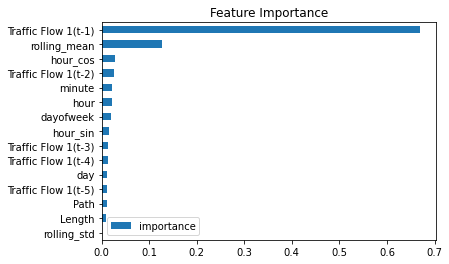

time: 688 ms (started: 2023-06-30 02:50:52 +03:00)


In [23]:
# Show how much each of the features was used in our regression analysis
plt.figure(figsize=(15,5))
fi = pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### Make predictions on the test set

In [24]:
y_pred = reg.predict(X)

time: 1.55 s (started: 2023-06-30 02:50:54 +03:00)


### Plot Train and Validation errors

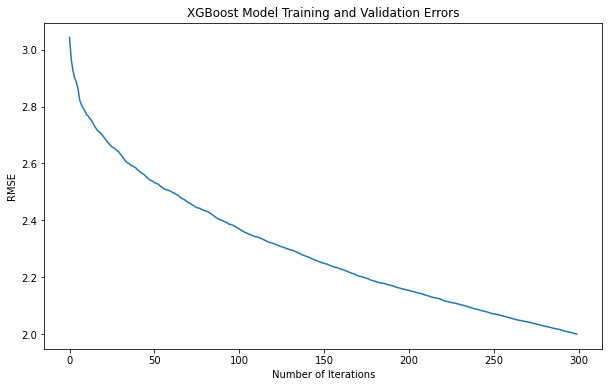

time: 313 ms (started: 2023-06-30 02:50:55 +03:00)


In [25]:
# acquire the values of train and validation errors
results = reg.evals_result()
train_errors = results['validation_0']['rmse']

# plot the validation and training errors
plt.figure(figsize=(10, 6))
plt.plot(train_errors)
plt.xlabel('Number of Iterations')
plt.ylabel('RMSE')
plt.title('XGBoost Model Training and Validation Errors')
plt.show()

### Evaluate the results

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate the MAE
mae = mean_absolute_error(Y, y_pred)
print("Mae is: ",mean_absolute_error(y, y_pred))

# Calculate RMSE score
rmse = mean_squared_error(y, y_pred, squared=False)
print("RMSE score:", rmse)

NameError: name 'Y' is not defined

time: 31 ms (started: 2023-06-30 02:51:30 +03:00)


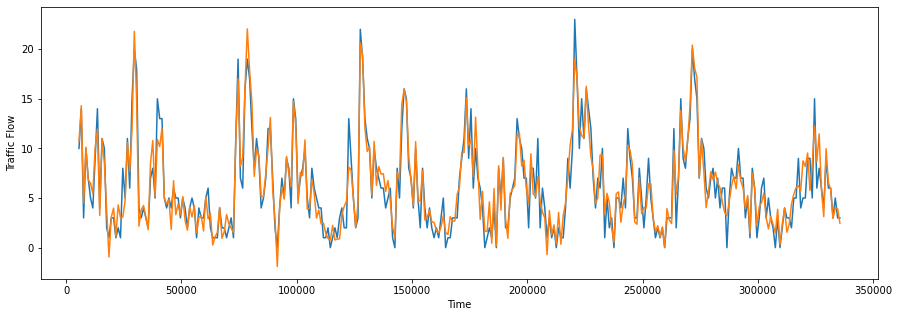

time: 218 ms (started: 2023-06-30 02:51:03 +03:00)


In [27]:
y['Predicted'] = y_pred
y['Path'] = X['Path']

# plot an example of the train-predictions
plt.figure(figsize=(15,5))
plt.plot(y[y['Path']==0][['Traffic Flow 1(t)','Predicted']])
plt.xlabel('Time')
plt.ylabel('Traffic Flow')
plt.show()

In [ ]:
y

### Forecast future traffic flow in each path

In [ ]:
# construct the test set with actual data and predicted
new_test = test
new_test.insert(3,'Predicted',y_pred)

### Train multiple XGboost models
Fit only the data of one path in each model

In [ ]:
# Define dataframe to save the scores
scores = pd.DataFrame(columns=['MAE','RMSE'],index=time_series.Path.unique())

In [ ]:
regressors = {}  # Dictionary to store regressor objects

for item in X_train['Path'].unique():
    
    sample = time_series[time_series['Path'] == item]
    
    # define train data
    s_train = sample.loc[sample['Time Column'] < '2008-05-24']
    s_train.sort_values(by='Time Column', inplace=True)

    # define test data
    s_test = sample.loc[sample['Time Column'] >= '2008-05-24']
    s_test.sort_values(by='Time Column', inplace=True)

    # define features
    s_features = sample.drop(['Time Column','Traffic Flow 1(t)'],axis=1).columns

    # define labels
    s_labels = ['Traffic Flow 1(t)']

    # create train set
    s_X_train = s_train[s_features]
    s_y_train = s_train[s_labels]

    # create test set
    s_X_test = s_test[s_features]
    s_y_test = s_test[s_labels]

    regressor_name = f"regressor_{item}"  # Name of the regressor
    
    print(regressor_name)
    
    regressors[regressor_name] = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators= 100,
        early_stopping_rounds=5,
        learning_rate=0.01,
        max_depth=5,
        gamma=0.3,
        alpha = 0.1
    )
    
    # Train the XGBoost model with feature weights
    reg.fit(s_X_train, s_y_train, eval_set=[(s_X_train,s_y_train), (s_X_test,s_y_test)], verbose=True)
    
    # Timeseries forecating on test set
    y_pred = reg.predict(s_X_test)
    
    # Calculate the MAE
    mae = mean_absolute_error(s_y_test, y_pred)

    # Calculate RMSE score
    rmse = mean_squared_error(s_y_test, y_pred, squared=False)
    
    scores.at[item,'MAE'] = mae
    scores.at[item,'RMSE'] = rmse
    
    break

In [ ]:
scores

In [ ]:
plt.plot(s_y_test['Traffic Flow 1(t)'].values)
plt.plot(y_pred)